#### Procesamiento Digital de Señales
# TS4: Primeras nociones de estimación espectral
#### Martin Sirito

#### Importo librerias
numpy, scipy, matplotlib

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
%matplotlib inline
plt.rcParams['figure.figsize'] = [14, 4]

#### Parametros de la simulacion

In [2]:
#%% Parametros de la simulación
a1 = np.sqrt(2) # Amplitud (para potencia normalizada)
nn = 1000       # Cantidad de muestras
rr = 200        # Cantidad de realizaciones
fs=nn
Ts = 1 / fs

W0 = fs / 4     # Mitad de la banda digital
snr = 10        # Señal a ruido
snr2 = 3
zpadding = 10   # zero padding

maxDispFrec = 0.5   # Dispersion de la frecuencia

correccion_flattop = 1#21.56045973

##### Generacion de señal con ruido
Generamos 'rr' senoidales, con frecuencia central 'W0' y una dispersion en frecuencia de 'maxDispFrec' y agregamos un ruido uniforme teniendo en cuenta la snr.

In [3]:
#%% Señal senoidal
### Dispersion en frecuencia
fr = np.random.uniform(-maxDispFrec, maxDispFrec, size = (1,rr))
W1 = W0 + fr

### Senoidal pura
tt = np.arange(0, nn*Ts, Ts).reshape(nn,1)  # Defino eje de tiempo
xx = a1 * np.sin(W1*2*np.pi * tt)           # Armo una senoidal pura

### Ruido uniforme
pow_noise = 10**(-snr/10)
vnoise = np.sqrt(pow_noise*12)
noise = np.random.uniform(-vnoise/2, vnoise/2, size = (nn,rr)) # Genero un ruido uniforme con la snr parametrizada

xr = xx + noise     # Le agrego el ruido a la señal
#xr = xx
### Defino ejes de frecuencia
# Sin zero padding
df = fs/nn
ff = np.linspace(0, (nn-1)*df, nn)
bfrec = ff <= fs/2

# Con zero padding
dfzpad = fs/(zpadding)/nn
ffzpad = np.linspace(0, ((zpadding)*nn-1)*dfzpad, (zpadding)*nn)
bfreczpad = ffzpad <= fs/2

#### Ventaneo BoxCar
Definimos una ventana rectangular para ventanear explicitamente

In [4]:
#%% Ventaneo boxcar (ventana implicita)
ventana_boxcar = sig.windows.boxcar(nn).reshape(nn,1)
xn_boxcar = xr * ventana_boxcar

## Sin zero padding
fft_sig_boxcar = np.fft.fft( xn_boxcar,    axis = 0 )/nn
dp_sig_boxcar = np.abs(fft_sig_boxcar[bfrec])**2
dp_sig_boxcar_db = 10* np.log10(2*dp_sig_boxcar)

## Con zero padding
xi_boxcar = np.vstack([xn_boxcar,np.zeros([(zpadding-1)*nn,rr])])
fft_sig_boxcar_zp = np.fft.fft( xi_boxcar,    axis = 0 )/nn
dp_sig_boxcar_zp = np.abs(fft_sig_boxcar_zp[bfreczpad])**2
dp_sig_boxcar_db_zp = 10* np.log10(2*dp_sig_boxcar_zp)

#### Ploteo de la transformada de fourier
Ploteamos la fft entera (grafico arriba) y haciendo zoom en el lóbulo principal (gráfico abajo).
Tambien graficamos la fft usando la tecnica de zero padding para aumentar la resolucion espectral.

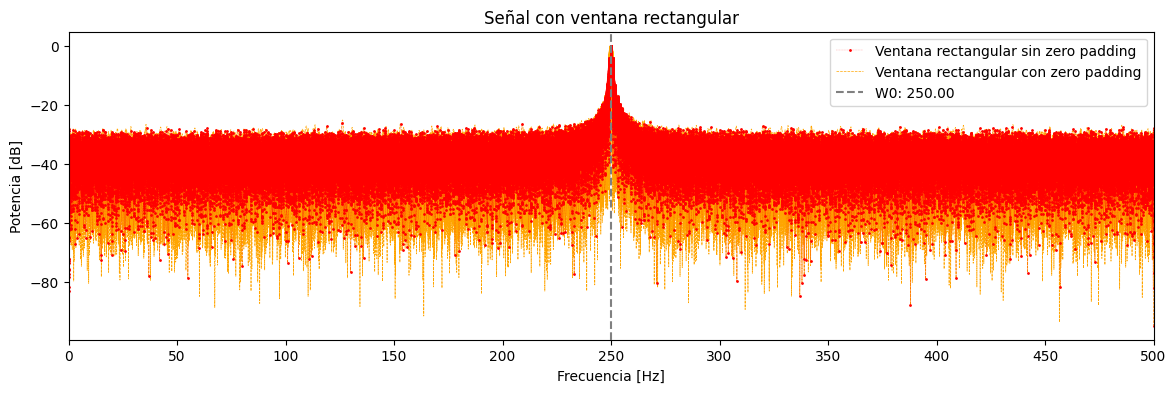

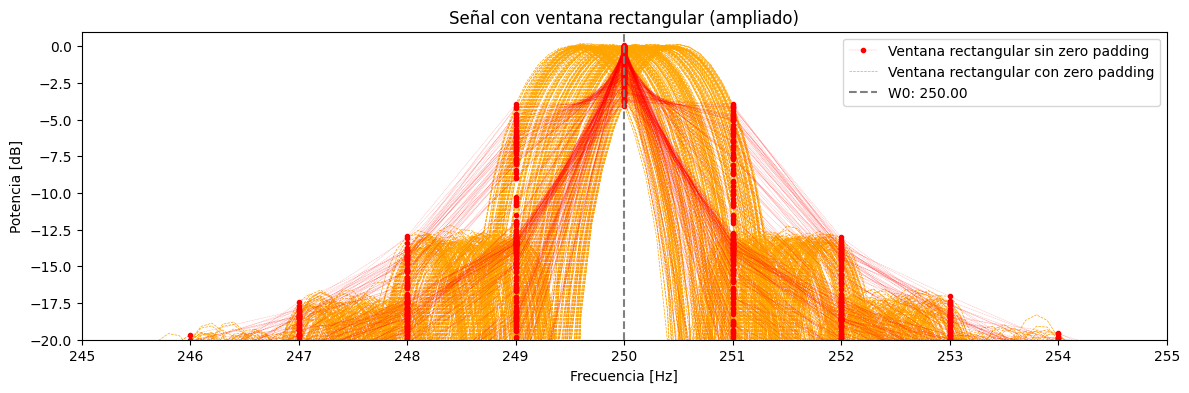

In [5]:
#%% Ploteo boxcar
plt.figure(1)
plt.title("Señal con ventana rectangular")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Potencia [dB]")
plt.plot( [], [], label="Ventana rectangular sin zero padding",color='red',    linestyle=':',  linewidth=.2,  marker='o', markersize=1)
plt.plot( ff[bfrec],         dp_sig_boxcar_db,    color='red',    linestyle=':',  linewidth=.2,  marker='o', markersize=1, zorder=1)
plt.plot( [], [], label="Ventana rectangular con zero padding",color='orange', linestyle='--', linewidth=.5)
plt.plot( ffzpad[bfreczpad], dp_sig_boxcar_db_zp, color='orange', linestyle='--', linewidth=.5, zorder=0)
plt.axvline(W0, color='grey', linestyle='--', label=f'W0: {W0:.2f}', zorder=10)
plt.legend(loc='upper right')
plt.xticks(np.arange(0, nn/2+1, nn/20))

plt.xlim([0, nn/2])

plt.figure(2)
plt.title("Señal con ventana rectangular (ampliado)")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Potencia [dB]")
plt.xlim([0, nn/2])
plt.plot( [], [], label="Ventana rectangular sin zero padding",color='red',    linestyle=':',  linewidth=.2,  marker='o', markersize=3)
plt.plot( ff[bfrec],         dp_sig_boxcar_db,    color='red',    linestyle=':',  linewidth=.2,  marker='o', markersize=3, zorder=1)
plt.plot( [], [], label="Ventana rectangular con zero padding",color='orange', linestyle='--', linewidth=.5)
plt.plot( ffzpad[bfreczpad], dp_sig_boxcar_db_zp, color='orange', linestyle='--', linewidth=.5, zorder=0)
plt.axvline(W0, color='grey', linestyle='--', label=f'W0: {W0:.2f}', zorder=10)
plt.legend(loc='upper right')
plt.xticks(np.arange(W0-5*df, W0+5*df+1, df))

plt.xlim(W0-5*df, W0+5*df)
plt.ylim(-20, 1)
plt.show()

#### Estimador de Amplitud a1
Para el estimador de amplitud tomamos los valores de amplitud de cada realizacion en el lóbulo principal de 250Hz, como se muestra en el grafico. Vemos que, tanto para la fft con y sin zero padding, el estimador va a ser el mismo

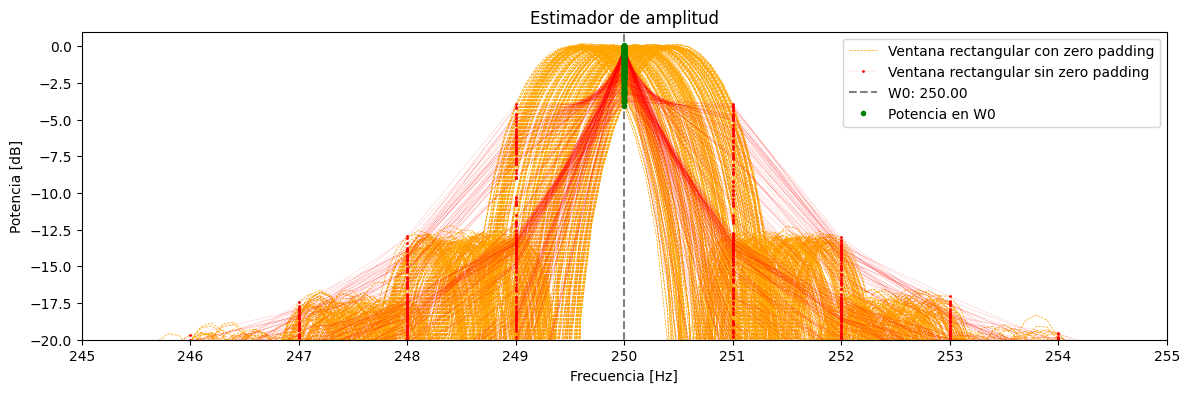

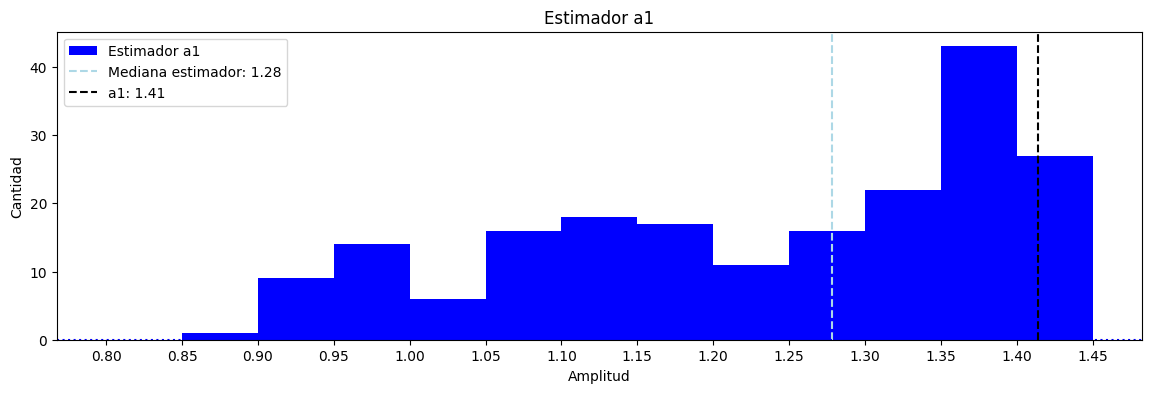

In [6]:
est_a1 = 2*np.abs(fft_sig_boxcar[250]) #Nos quedamos con el valor en W0
est_a1_db = 10* np.log10(est_a1**2/2)
mediana_a1 = np.median(est_a1)
sesgo_a1 = mediana_a1 - a1
varianza_a1 = np.var(est_a1)

plt.figure(1)
plt.title("Estimador de amplitud")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Potencia [dB]")
plt.xlim([0, nn/2])
plt.plot( [], [], label="Ventana rectangular con zero padding",color='orange', linestyle='--', linewidth=.5)
plt.plot( ffzpad[bfreczpad], dp_sig_boxcar_db_zp, color='orange', linestyle='--', linewidth=.5, zorder=0)
plt.plot( [], [], label="Ventana rectangular sin zero padding",color='red',    linestyle=':',  linewidth=.2, marker='o', markersize=1)
plt.plot( ff[bfrec],         dp_sig_boxcar_db,    color='red',    linestyle=':',  linewidth=.2, zorder=1, marker='o', markersize=1)
plt.axvline(W0, color='grey', linestyle='--', label=f'W0: {W0:.2f}', zorder=10)
plt.xlim(W0-5*df, W0+5*df)
plt.ylim(-20, 1)
plt.plot( [], [], label="Potencia en W0",color='green',    linestyle=' ',  marker='o', markersize=3, zorder=1)
plt.plot( np.ones(200)*250, est_a1_db, color='green',    linestyle=' ',  marker='o', markersize=3, zorder=10)
plt.legend(loc='upper right')
plt.xticks(np.arange(W0-5*df, W0+5*df+1, df))

plt.figure(4)
plt.title("Estimador a1")
plt.xlabel("Amplitud")
plt.ylabel("Cantidad")
bins = np.arange(.8, 1.5, .05)
plt.hist( est_a1,  color='blue', label = 'Estimador a1', bins = bins)
plt.xticks(bins)
plt.axvline(mediana_a1, color='lightblue', linestyle='--', label=f'Mediana estimador: {mediana_a1:.2f}')
plt.axvline(np.mean(a1), color='black', linestyle='--', label=f'a1: {a1:.2f}')
plt.legend(loc='upper left')
plt.axhline(0,  color='blue', linestyle=':', label='0dB')
plt.show()

A partir de los valores que toma las distintas realizaciones en su lobulo principal podemos calcular el valor medio, el sesgo y la varianza del estimador de a1

In [7]:
print("a1 esperado:           " + str(a1))
print("Mediana estimador a1:  " + str(mediana_a1))
print("Sesgo estimador a1:    " + str(sesgo_a1))
print("Varianza estimador a1: " + str(varianza_a1))

a1 esperado:           1.4142135623730951
Mediana estimador a1:  1.2784866423215395
Sesgo estimador a1:    -0.13572692005155562
Varianza estimador a1: 0.024036845615865207


#### Estimador de Frecuencia W1
Para el estimador de frecuencia tomamos los valores de frecuenca para la amplitud maxima de cada realizacion. Vemos que, para la fft con zero padding y sin zero padding, el estimador difiere.

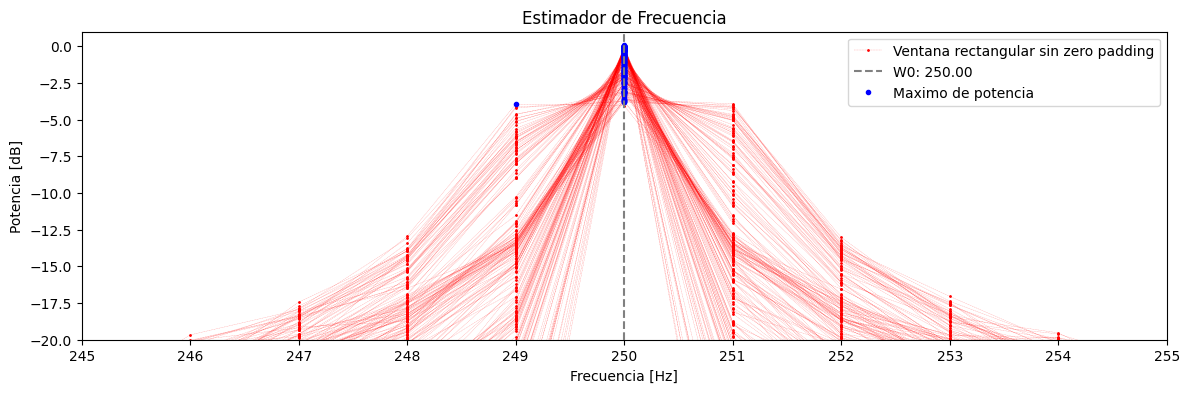

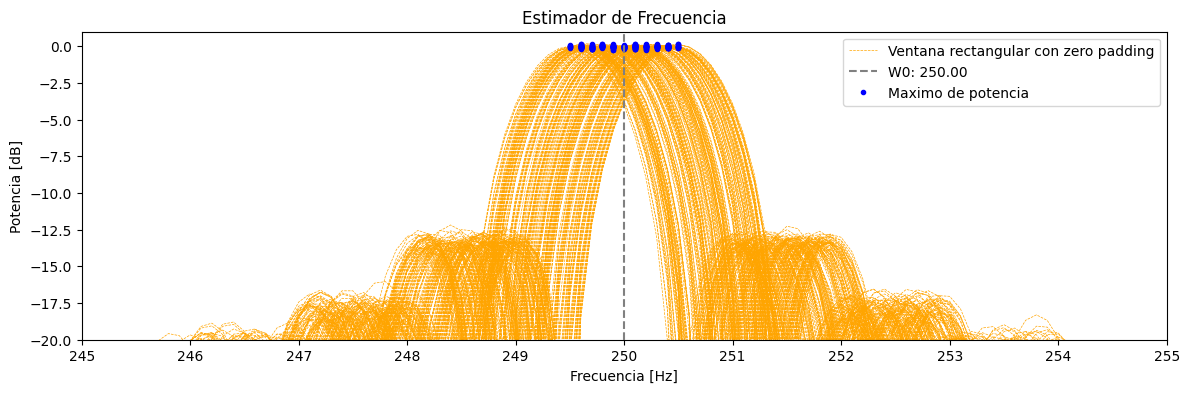

In [8]:
est_W1 = ff[np.argmax(dp_sig_boxcar,axis=0)]
max_values = np.max(dp_sig_boxcar_db,axis=0)
mediana_W1 = np.median(est_W1)
sesgo_W1 = mediana_W1 - W0
varianza_W1 = np.var(est_W1)

est_W1_zp = ffzpad[np.argmax(dp_sig_boxcar_zp,axis=0)]
max_values_zp = np.max(dp_sig_boxcar_db_zp,axis=0)
mediana_W1_zp = np.median(est_W1_zp)
sesgo_W1_zp = mediana_W1_zp - W0
varianza_W1_zp = np.var(est_W1_zp)

plt.figure(5)
plt.title("Estimador de Frecuencia")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Potencia [dB]")
plt.xlim([0, nn/2])
plt.plot( [], [], label="Ventana rectangular sin zero padding",color='red',    linestyle=':',  linewidth=.2, marker='o', markersize=1)
plt.plot( ff[bfrec],         dp_sig_boxcar_db,    color='red',    linestyle=':',  linewidth=.2, zorder=1, marker='o', markersize=1)
plt.axvline(W0, color='grey', linestyle='--', label=f'W0: {W0:.2f}', zorder=10)
plt.xlim(W0-5*df, W0+5*df)
plt.ylim(-20, 1)
plt.plot( [], [], label="Maximo de potencia",color='blue',    linestyle=' ',  marker='o', markersize=3, zorder=1)
plt.plot( est_W1, max_values, color='blue',    linestyle=' ',  marker='o', markersize=3, zorder=1)
plt.legend(loc='upper right')
plt.xticks(np.arange(W0-5*df, W0+5*df+1, df))

plt.figure(6)
plt.title("Estimador de Frecuencia")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Potencia [dB]")
plt.xlim([0, nn/2])
plt.plot( [], [], label="Ventana rectangular con zero padding",color='orange', linestyle='--', linewidth=.5)
plt.plot( ffzpad[bfreczpad], dp_sig_boxcar_db_zp, color='orange', linestyle='--', linewidth=.5, zorder=0)
plt.axvline(W0, color='grey', linestyle='--', label=f'W0: {W0:.2f}', zorder=10)
plt.xlim(W0-5*df, W0+5*df)
plt.ylim(-20, 1)
plt.plot( [], [], label="Maximo de potencia",color='blue',    linestyle=' ',  marker='o', markersize=3, zorder=1)
plt.plot( est_W1_zp, max_values_zp, color='blue',    linestyle=' ',  marker='o', markersize=3, zorder=1)
plt.legend(loc='upper right')
plt.xticks(np.arange(W0-5*df, W0+5*df+1, df))
plt.show()

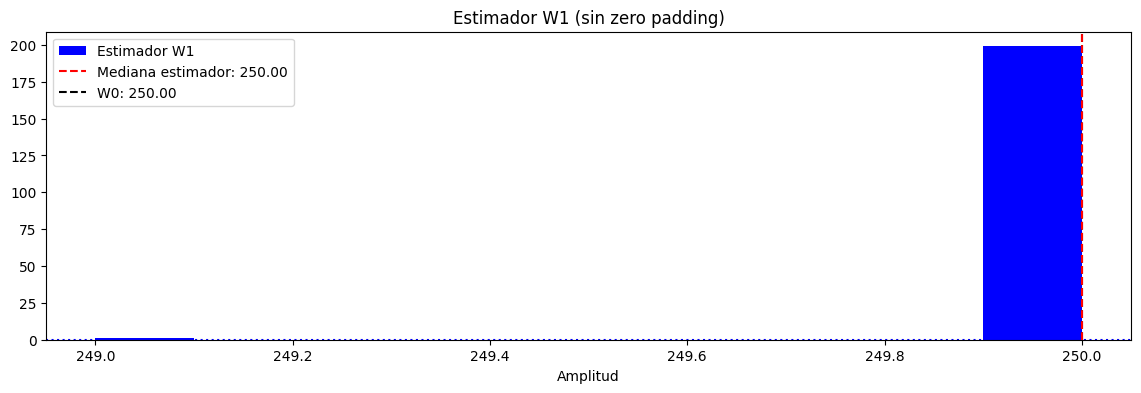

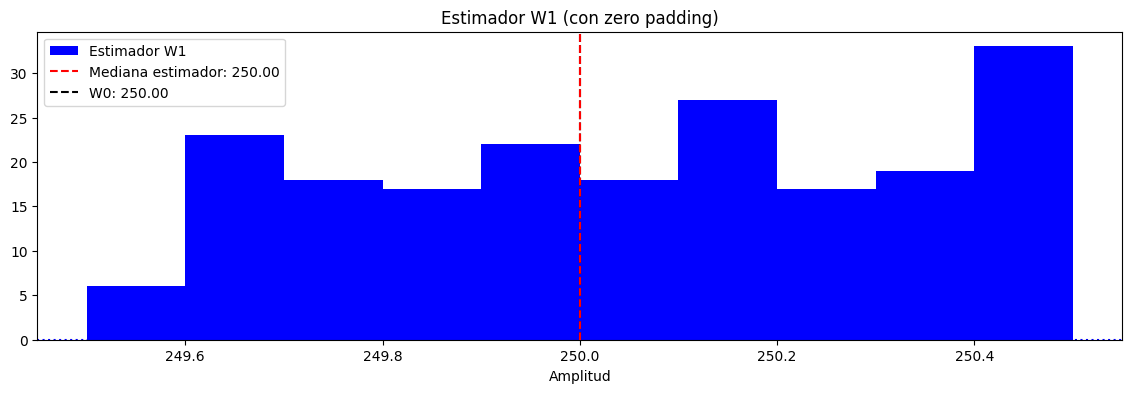

In [9]:
plt.figure(7)
plt.title("Estimador W1 (sin zero padding)")
plt.xlabel("Amplitud")
plt.hist( est_W1,  color='blue', label = 'Estimador W1')
plt.axvline(mediana_W1, color='red', linestyle='--', label=f'Mediana estimador: {mediana_W1:.2f}',zorder = 10)
plt.axvline(W0, color='black', linestyle='--', label=f'W0: {W0:.2f}')
plt.legend(loc='upper left')
plt.axhline(0,  color='blue', linestyle=':', label='0dB')

plt.figure(8)
plt.title("Estimador W1 (con zero padding)")
plt.xlabel("Amplitud")
plt.hist( est_W1_zp,  color='blue', label = 'Estimador W1')
plt.axvline(mediana_W1_zp, color='red', linestyle='--', label=f'Mediana estimador: {mediana_W1_zp:.2f}',zorder = 10)
plt.axvline(W0, color='black', linestyle='--', label=f'W0: {W0:.2f}')
plt.legend(loc='upper left')
plt.axhline(0,  color='blue', linestyle=':', label='0dB')
plt.show()

A partir de los valores de frecuenca obtenidos para los valores maximos de amlitud que toman las distintas realizaciones el valor medio, el sesgo y la varianza del estimador de W1

In [10]:
print("W1 esperado:           " + str(W0))
print("Mediana estimador W1:  " + str(mediana_W1))
print("Sesgo estimador W1:    " + str(sesgo_W1))
print("Varianza estimador W1: " + str(varianza_W1))

W1 esperado:           250.0
Mediana estimador W1:  250.0
Sesgo estimador W1:    0.0
Varianza estimador W1: 0.004974999999999999


Y para el zpadding

In [11]:
print("W1 esperado:           " + str(W0))
print("Mediana estimador W1:  " + str(mediana_W1_zp))
print("Sesgo estimador W1:    " + str(sesgo_W1_zp))
print("Varianza estimador W1: " + str(varianza_W1_zp))

W1 esperado:           250.0
Mediana estimador W1:  250.0
Sesgo estimador W1:    0.0
Varianza estimador W1: 0.08293974999999847


### Para SNR de 3dB
Volvemos a hacer el procedimiento pero para una snr de 3dB

In [12]:
### Senoidal pura (usamos la misma senoidal limpia que usamos para la primera señal)

### Ruido uniforme
pow_noise = 10**(-snr2/10)
vnoise = np.sqrt(pow_noise*12)
noise = np.random.uniform(-vnoise/2, vnoise/2, size = (nn,rr)) # Genero un ruido uniforme con la snr parametrizada
xr = xx + noise     # Le agrego el ruido a la señal

#%% Ventaneo boxcar (ventana implicita)
ventana_boxcar = sig.windows.boxcar(nn).reshape(nn,1)
xn_boxcar = xr * ventana_boxcar

dp_sig_boxcar_db_orig = dp_sig_boxcar_db #Guardo el valor oringinal
## Sin zero padding
fft_sig_boxcar = np.fft.fft( xn_boxcar,    axis = 0 )/nn
dp_sig_boxcar = np.abs(fft_sig_boxcar[bfrec])**2
dp_sig_boxcar_db = 10* np.log10(2*dp_sig_boxcar)

dp_sig_boxcar_db_zp_orig = dp_sig_boxcar_db_zp #Guardo el valor oringinal
## Con zero padding
xi_boxcar = np.vstack([xn_boxcar,np.zeros([(zpadding-1)*nn,rr])])
fft_sig_boxcar_zp = np.fft.fft( xi_boxcar,    axis = 0 )/nn
dp_sig_boxcar_zp = np.abs(fft_sig_boxcar_zp[bfreczpad])**2
dp_sig_boxcar_db_zp = 10* np.log10(2*dp_sig_boxcar_zp)

#Guardo los  valores originales
est_a1_orig = est_a1
mediana_a1_orig = mediana_a1
sesgo_a1_orig = mediana_a1 - a1
varianza_a1_orig = np.var(est_a1)

est_W1_orig = est_W1
mediana_W1_orig = mediana_W1
sesgo_W1_orig = sesgo_W1
varianza_W1_orig = varianza_W1

est_W1_zp_orig = est_W1_zp
mediana_W1_zp_orig = mediana_W1_zp
sesgo_W1_zp_orig = sesgo_W1_zp
varianza_W1_zp_orig = varianza_W1_zp

est_a1 = 2*np.abs(fft_sig_boxcar[250]) #Nos quedamos con el valor en W0
est_a1_db = 10* np.log10(est_a1**2/2)
mediana_a1 = np.median(est_a1)
sesgo_a1 = mediana_a1 - a1
varianza_a1 = np.var(est_a1)

est_W1 = ff[np.argmax(dp_sig_boxcar,axis=0)]
max_values = np.max(dp_sig_boxcar_db,axis=0)
mediana_W1 = np.median(est_W1)
sesgo_W1 = mediana_W1 - W0
varianza_W1 = np.var(est_W1)

est_W1_zp = ffzpad[np.argmax(dp_sig_boxcar_zp,axis=0)]
max_values_zp = np.max(dp_sig_boxcar_db_zp,axis=0)
mediana_W1_zp = np.median(est_W1_zp)
sesgo_W1_zp = mediana_W1_zp - W0
varianza_W1_zp = np.var(est_W1_zp)

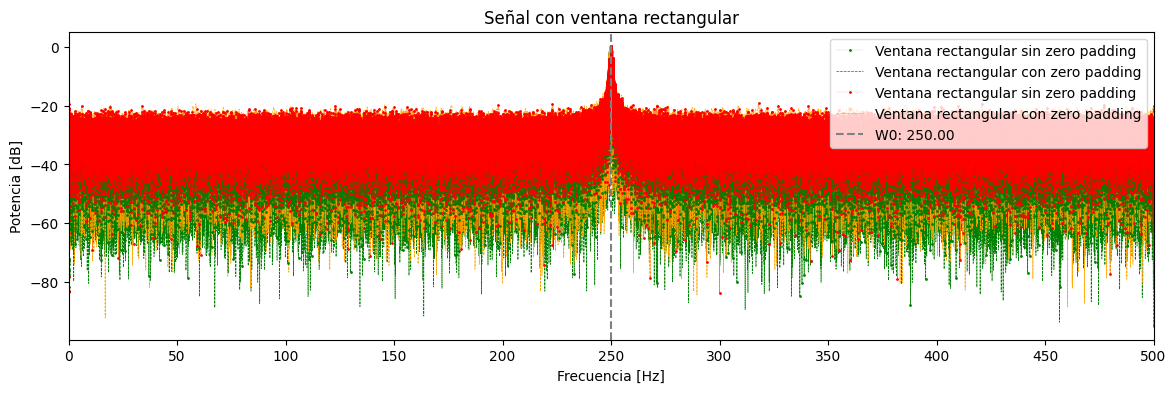

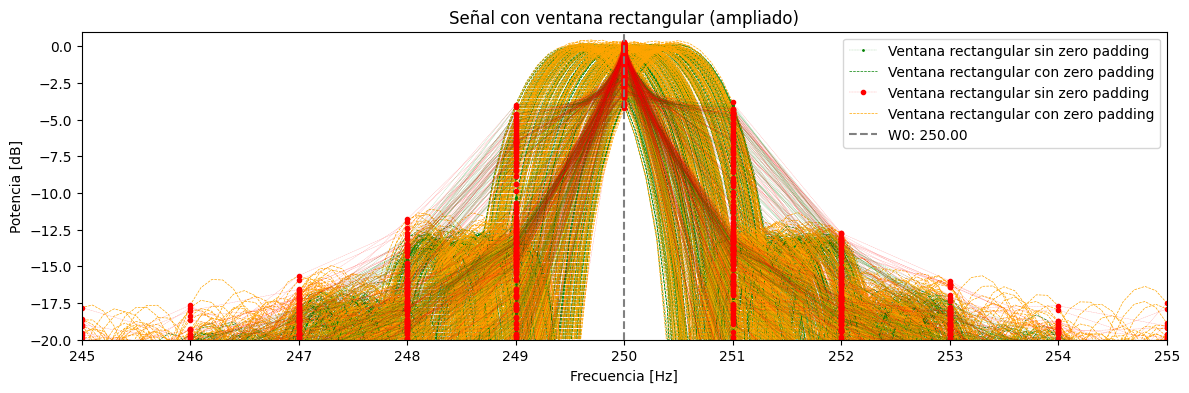

In [13]:
#%% Ploteo boxcar
plt.figure(1)
plt.title("Señal con ventana rectangular")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Potencia [dB]")
plt.plot( [], [], label="Ventana rectangular sin zero padding",color='green',    linestyle=':',  linewidth=.2,  marker='o', markersize=1)
plt.plot( ff[bfrec],         dp_sig_boxcar_db_orig,    color='green',    linestyle=':',  linewidth=.2,  marker='o', markersize=1, zorder=1)
plt.plot( [], [], label="Ventana rectangular con zero padding",color='green', linestyle='--', linewidth=.5)
plt.plot( ffzpad[bfreczpad], dp_sig_boxcar_db_zp_orig, color='green', linestyle='--', linewidth=.5, zorder=0)
plt.plot( [], [], label="Ventana rectangular sin zero padding",color='red',    linestyle=':',  linewidth=.2,  marker='o', markersize=1)
plt.plot( ff[bfrec],         dp_sig_boxcar_db,    color='red',    linestyle=':',  linewidth=.2,  marker='o', markersize=1, zorder=1)
plt.plot( [], [], label="Ventana rectangular con zero padding",color='orange', linestyle='--', linewidth=.5)
plt.plot( ffzpad[bfreczpad], dp_sig_boxcar_db_zp, color='orange', linestyle='--', linewidth=.5, zorder=0)
plt.axvline(W0, color='grey', linestyle='--', label=f'W0: {W0:.2f}', zorder=10)
plt.legend(loc='upper right')
plt.xticks(np.arange(0, nn/2+1, nn/20))

plt.xlim([0, nn/2])

plt.figure(2)
plt.title("Señal con ventana rectangular (ampliado)")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Potencia [dB]")
plt.xlim([0, nn/2])
plt.plot( [], [], label="Ventana rectangular sin zero padding",color='green',    linestyle=':',  linewidth=.2,  marker='o', markersize=1)
plt.plot( ff[bfrec],         dp_sig_boxcar_db_orig,    color='green',    linestyle=':',  linewidth=.2,  marker='o', markersize=1, zorder=1)
plt.plot( [], [], label="Ventana rectangular con zero padding",color='green', linestyle='--', linewidth=.5)
plt.plot( ffzpad[bfreczpad], dp_sig_boxcar_db_zp_orig, color='green', linestyle='--', linewidth=.5, zorder=0)
plt.plot( [], [], label="Ventana rectangular sin zero padding",color='red',    linestyle=':',  linewidth=.2,  marker='o', markersize=3)
plt.plot( ff[bfrec],         dp_sig_boxcar_db,    color='red',    linestyle=':',  linewidth=.2,  marker='o', markersize=3, zorder=1)
plt.plot( [], [], label="Ventana rectangular con zero padding",color='orange', linestyle='--', linewidth=.5)
plt.plot( ffzpad[bfreczpad], dp_sig_boxcar_db_zp, color='orange', linestyle='--', linewidth=.5, zorder=0)
plt.axvline(W0, color='grey', linestyle='--', label=f'W0: {W0:.2f}', zorder=10)
plt.legend(loc='upper right')
plt.xticks(np.arange(W0-5*df, W0+5*df+1, df))

plt.xlim(W0-5*df, W0+5*df)
plt.ylim(-20, 1)
plt.show()

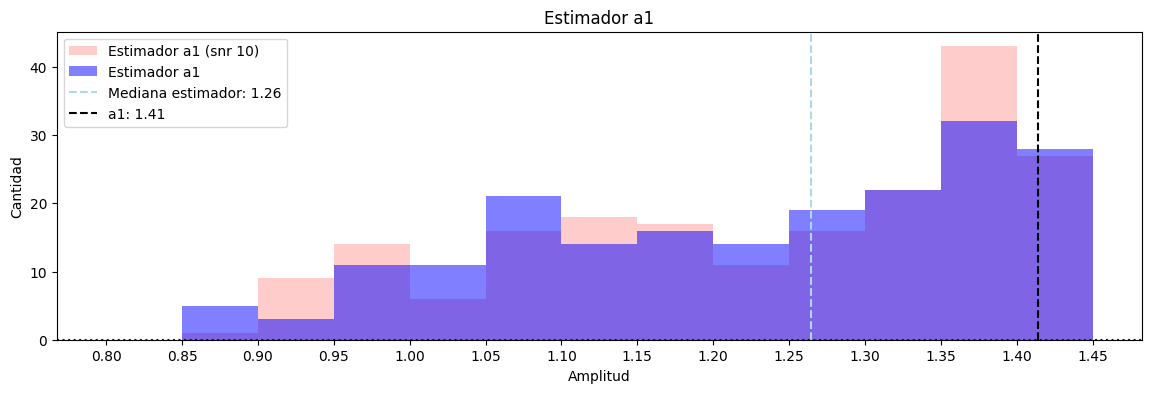

In [14]:
plt.figure(4)
plt.title("Estimador a1")
plt.xlabel("Amplitud")
plt.ylabel("Cantidad")
bins = np.arange(.8, 1.5, .05)
plt.hist( est_a1_orig,  color='red', label = 'Estimador a1 (snr 10)', bins = bins, alpha=0.2)
plt.hist( est_a1,  color='blue', label = 'Estimador a1', bins = bins, alpha = 0.5)
plt.xticks(bins)
plt.axvline(mediana_a1, color='lightblue', linestyle='--', label=f'Mediana estimador: {mediana_a1:.2f}')
plt.axvline(np.mean(a1), color='black', linestyle='--', label=f'a1: {a1:.2f}')
plt.legend(loc='upper left')
plt.axhline(0,  color='blue', linestyle=':', label='0dB')
plt.show()

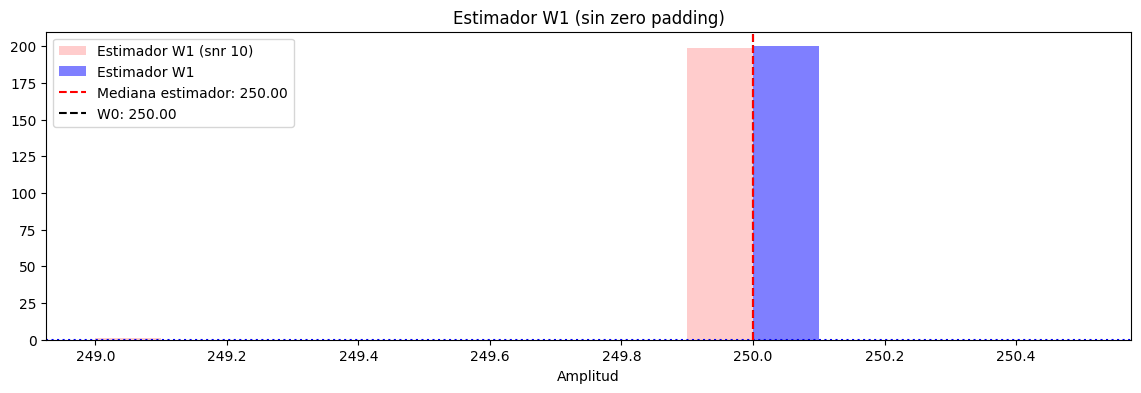

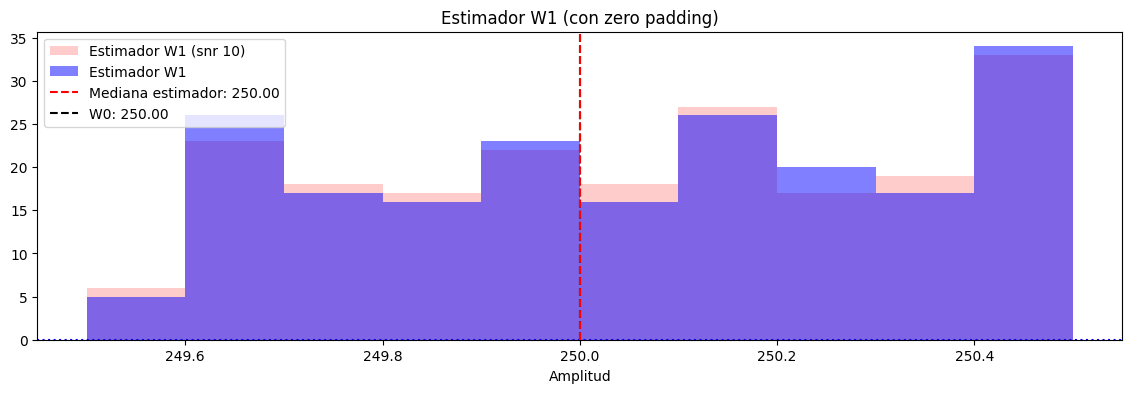

In [15]:
plt.figure(7)
plt.title("Estimador W1 (sin zero padding)")
plt.xlabel("Amplitud")
plt.hist( est_W1_orig,  color='red', label = 'Estimador W1 (snr 10)',  alpha=0.2)
plt.hist( est_W1,  color='blue', label = 'Estimador W1',  alpha = 0.5)
plt.axvline(mediana_W1, color='red', linestyle='--', label=f'Mediana estimador: {mediana_W1:.2f}',zorder = 10)
plt.axvline(W0, color='black', linestyle='--', label=f'W0: {W0:.2f}')
plt.legend(loc='upper left')
plt.axhline(0,  color='blue', linestyle=':', label='0dB')

plt.figure(8)
plt.title("Estimador W1 (con zero padding)")
plt.xlabel("Amplitud")
plt.hist( est_W1_zp_orig,  color='red', label = 'Estimador W1 (snr 10)',  alpha=0.2)
plt.hist( est_W1_zp,  color='blue', label = 'Estimador W1',  alpha = 0.5)
plt.axvline(mediana_W1_zp, color='red', linestyle='--', label=f'Mediana estimador: {mediana_W1_zp:.2f}',zorder = 10)
plt.axvline(W0, color='black', linestyle='--', label=f'W0: {W0:.2f}')
plt.legend(loc='upper left')
plt.axhline(0,  color='blue', linestyle=':', label='0dB')
plt.show()

In [16]:
import pandas as pd

# Define the data for the table
data = {'SnR Señal': ['10dB', '3dB'],
        'a1 esperado': [a1, a1],
        'Mediana a1': [mediana_a1_orig, mediana_a1],
        'Sesgo a1': [sesgo_a1_orig, sesgo_a1],
        'Varianza a1': [varianza_a1_orig, varianza_a1],
        'W0 esperado': [W0, W0],
        'Mediana W1': [mediana_W1_orig, mediana_W1],
        'Sesgo W1': [sesgo_W1_orig, sesgo_W1],
        'Varianza W1': [varianza_W1_orig, varianza_W1]}

# Create a pandas DataFrame from the data
df = pd.DataFrame(data)

# Define the data for the table
data_zp = {'SnR Señal': ['10dB (zero pad)', '3dB (zero pad)'],
        'a1 esperado': [a1, a1],
        'Mediana a1': [mediana_a1_orig, mediana_a1],
        'Sesgo a1': [sesgo_a1_orig, sesgo_a1],
        'Varianza a1': [varianza_a1_orig, varianza_a1],
        'W0 esperado': [W0, W0],
        'Mediana W1': [mediana_W1_zp_orig, mediana_W1_zp],
        'Sesgo W1': [sesgo_W1_zp_orig, sesgo_W1_zp],
        'Varianza W1': [varianza_W1_zp_orig, varianza_W1_zp]}

# Create a pandas DataFrame from the data
df_zp = pd.DataFrame(data_zp)

# Display the DataFrame as a table
combined_df = pd.concat([df, df_zp], axis=0)
combined_df.style.hide(axis="index")

SnR Señal,a1 esperado,Mediana a1,Sesgo a1,Varianza a1,W0 esperado,Mediana W1,Sesgo W1,Varianza W1
10dB,1.414214,1.278487,-0.135727,0.024037,250.000000,250.000000,0.000000,0.004975
3dB,1.414214,1.264760,-0.149453,0.024707,250.000000,250.000000,0.000000,0.000000
10dB (zero pad),1.414214,1.278487,-0.135727,0.024037,250.000000,250.000000,0.000000,0.082940
3dB (zero pad),1.414214,1.264760,-0.149453,0.024707,250.000000,250.000000,0.000000,0.085244


Como podemos ver, 

## Otras ventanas

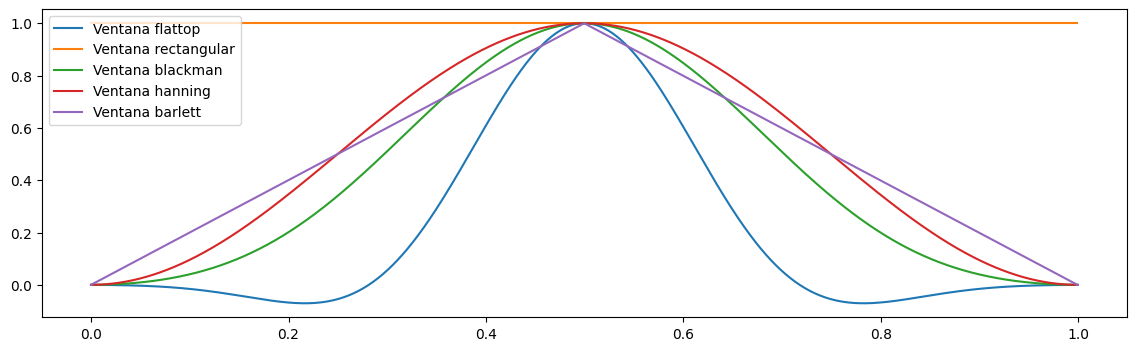

In [20]:
# Ventana flattop
ventana_flattop = sig.windows.flattop(nn).reshape(nn,1)
xn_flattop = xr * ventana_flattop

## Sin zero padding
fft_sig_flattop   = np.fft.fft( xn_flattop,    axis = 0 )/nn
dp_sig_flattop   = np.abs(fft_sig_flattop[bfrec])**2 * correccion_flattop

## Con zero padding
xi_flattop = np.vstack([xn_flattop,np.zeros([(zpadding-1)*nn,rr])])
fft_sig_flattop_zp = np.fft.fft( xi_flattop,    axis = 0 )/nn
dp_sig_flattop_zp = np.abs(fft_sig_flattop_zp[bfreczpad])**2 * correccion_flattop

# Ventana Hanning (Hamming)
ventana_hanning = sig.windows.hann(nn).reshape(nn, 1)
xn_hanning = xr * ventana_hanning

## Sin zero padding
fft_sig_hanning   = np.fft.fft( xn_hanning,    axis = 0 )/nn
dp_sig_hanning   = np.abs(fft_sig_hanning[bfrec])**2

## Con zero padding
xi_hanning = np.vstack([xn_hanning,np.zeros([(zpadding-1)*nn,rr])])
fft_sig_hanning_zp = np.fft.fft( xi_hanning,    axis = 0 )/nn
dp_sig_hanning_zp = np.abs(fft_sig_hanning_zp[bfreczpad])**2

# Ventana Blackman
ventana_blackman = sig.windows.blackman(nn).reshape(nn, 1)

# Ventana Bartlett (Triangular)
ventana_bartlett = sig.windows.bartlett(nn).reshape(nn, 1)

##PLOTEO
plt.figure(11)
plt.plot(tt, ventana_flattop, label = 'Ventana flattop')
plt.plot(tt, ventana_boxcar, label = 'Ventana rectangular')
plt.plot(tt, ventana_blackman, label = 'Ventana blackman')
plt.plot(tt, ventana_hanning, label = 'Ventana hanning')
plt.plot(tt, ventana_bartlett, label = 'Ventana barlett')
plt.legend(loc='upper left')